In [1]:
import pandas as pd
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv('cricsheet_master_data.csv')

----------------------------------

## Step 1: Basic shape and columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278205 entries, 0 to 278204
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   match_id                278205 non-null  int64  
 1   season                  278205 non-null  object 
 2   start_date              278205 non-null  object 
 3   venue                   278205 non-null  object 
 4   innings                 278205 non-null  int64  
 5   ball                    278205 non-null  float64
 6   batting_team            278205 non-null  object 
 7   bowling_team            278205 non-null  object 
 8   striker                 278205 non-null  object 
 9   non_striker             278205 non-null  object 
 10  bowler                  278205 non-null  object 
 11  runs_off_bat            278205 non-null  int64  
 12  extras                  278205 non-null  int64  
 13  wides                   9080 non-null    float64
 14  noballs             

In [4]:
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nSample rows:")
df.head(3)

Shape: (278205, 22)

Columns:
 ['match_id', 'season', 'start_date', 'venue', 'innings', 'ball', 'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler', 'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type', 'other_player_dismissed']

Sample rows:


,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,598068,2013,2013-05-18,M Chinnaswamy Stadium,1,0.1,Royal Challengers Bangalore,Chennai Super Kings,V Kohli,CH Gayle,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,598068,2013,2013-05-18,M Chinnaswamy Stadium,1,0.2,Royal Challengers Bangalore,Chennai Super Kings,V Kohli,CH Gayle,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,598068,2013,2013-05-18,M Chinnaswamy Stadium,1,0.3,Royal Challengers Bangalore,Chennai Super Kings,V Kohli,CH Gayle,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-----------------------------

## Step 2: Understand unique values in key columns

In [5]:
print("Innings values:", df['innings'].unique())
print("Season values:", df['season'].unique())
print("Total matches:", df['match_id'].nunique())
print("Total teams:", df['batting_team'].nunique())

Innings values: [1 2 3 4 5 6]
Season values: ['2013' '2022' '2020/21' '2015' '2024' '2007/08' '2025' '2012' '2017'
 '2011' '2016' '2021' '2009/10' '2019' '2014' '2009' '2018' '2023']
Total matches: 1169
Total teams: 19


* *RED FLAG 1*
* Inning values go up to 6. It should be 1 to 2 for normal match.
* 3,4,5,6 ==> are super overs, each super over bring two more innings
  
* MOST IMPORTANT PART FOR THE MODEL
  
  
* super overs completely follows the different rules
* 1 over, max 2 wickets
* If we include this in win probability model
* It will corrept features like ==> run rate and balls remaining
  

* *RED FLAG 2*
* In seasons values ==> we have different format
* 2020/21   2007/08    2009/10
* This need to be standardized before any time base analysis
  


* *RED FLAG 3*
* In this data set we have 15 total teams
* currently we have only 10 teams

------------------------------------------

## INVESTIGATING 3 RED FLAGS

1. CHECKING FOR SUPER OVERS

In [6]:
print(df['innings'].value_counts())

innings
1    144131
2    133903
3        83
4        76
5         8
6         4
Name: count, dtype: int64


* FINDINGS 1
  
1. Innings imbalance (1 vs 2)

Innings 1 → 144,131 balls
Innings 2 → 133,903 balls

why inning 1 is bigger than inning 2. 
In innings 2, if the chasing team wins before all 20 overs, the match stops early. So innings 2 naturally has fewer balls. This is expected and correct ==> not a data error.

2. Innings 3,4,5,6 = Super Overs
3. 171 rows total out of 278,205
4. we will drop this for our model

-------------------------------------------------------------

2. CHECK ALL TEAM NAMES

In [7]:
print(sorted(df['batting_team'].unique()))

['Chennai Super Kings', 'Deccan Chargers', 'Delhi Capitals', 'Delhi Daredevils', 'Gujarat Lions', 'Gujarat Titans', 'Kings XI Punjab', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Lucknow Super Giants', 'Mumbai Indians', 'Pune Warriors', 'Punjab Kings', 'Rajasthan Royals', 'Rising Pune Supergiant', 'Rising Pune Supergiants', 'Royal Challengers Bangalore', 'Royal Challengers Bengaluru', 'Sunrisers Hyderabad']


* FINDINGS 2

'Royal Challengers Bangalore'

'Royal Challengers Bengaluru'  ==> same team, city renamed in 2024





'Kochi Tuskers Kerala'   ← defunct team, existed only in 2011
'Pune Warriors'          ← defunct team, existed 2011-2013
'Gujarat Lions'          ← existed only 2016-2017

1. we will keep this team, because it represent historical matches


------------------------------------------------------------------------------------------------

3. CHECKING FOR SEASON DISTRIBUTION

In [8]:
print(df.groupby('season')['match_id'].nunique().sort_values())

season
2009       57
2007/08    58
2017       59
2015       59
2021       60
2020/21    60
2019       60
2018       60
2016       60
2014       60
2009/10    60
2024       71
2011       73
2012       74
2022       74
2023       74
2025       74
2013       76
Name: match_id, dtype: int64


* FINDING 3

1. season format

'2007/08'  '2009/10'  '2020/21'  ← slash format
'2022'  '2023'  '2024'           ← year only format

2. we need to stadardize
3. slash format means tournament spanned two calander years
4. IPL seasons that span two years like '2007/08' mean the tournament started in 2007 and ended in 2008.
5. '2007/08' is not "half 2007 data + half 2008 data." It is simply IPL Season 1, which happened to run across two calendar years.

------------------------------------------------------------------------------------------------

## FIX 1 DROPING SUPER OVER FROM INNINGS (3,4,5,6)

In [9]:
df = df[~((df['innings'] == 3) | (df['innings'] == 4) | (df['innings'] == 5) | (df['innings'] == 6))]

------------------------------------------------------------------------------------

## FIX 2 RCB TEAM NAME

In [10]:
team_rename_map = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings',
    'Rising Pune Supergiants': 'Rising Pune Supergiant',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Royal Challengers Bangalore' : 'Royal Challengers Bengaluru'
}

# Apply the mapping to both batting and bowling teams
df['batting_team'] = df['batting_team'].replace(team_rename_map)
df['bowling_team'] = df['bowling_team'].replace(team_rename_map)

------------------------------------------------------------

## FIX 3 STANDARDIZE SEASON FORMAT

In [11]:
df['season'] = df['season'].str[0:4]

------------------------------------------------

## FIX 4 EXTRAS

Fixing "Extras" (Missing Values):
* In the raw data, if a ball wasn't a wide or a no-ball, the cell was empty (NaN).
* I filled all NaN values in wides, noballs, byes, legbyes, and penalty with 0. This allows us to perform mathematical operations.

In [12]:
# List of columns that should be 0 instead of NaN
cols_to_fix = ['extras', 'wides', 'noballs', 'byes', 'legbyes', 'penalty']

# Apply fillna to all these columns at once
df[cols_to_fix] = df[cols_to_fix].fillna(0)

------------------------------------------------

## FIX 5 WICKETS NULL

1. Instead of leaving them as NaN, we fill them with a string like "None".
2. This prevents errors when you start grouping data or building models
3. wicket types ==> types of wicket like catch out, runout, lbw etc.
4. player_dismissed ==> name of the player who got out

In [13]:
df['wicket_type'] = df['wicket_type'].fillna('no wicket') 
df['player_dismissed'] = df['player_dismissed'].fillna('none')

------------------------------------------------

## FIX 6 DROP EMPTY COLUMNS

1. The columns other_wicket_type and other_player_dismissed are 100% empty (every single row is null). Keeping them adds "noise" to your data and takes up memory.

2. In cricket both the player who got out is very rare, so most of the rows are empty.

In [14]:
df.drop(columns=['other_wicket_type', 'other_player_dismissed'], inplace=True)

-------------------------------

## FIX 7 VENUE ANOMALY

In [15]:
## CHECKING WHAT IS WRONG HERE

print("Total unique venues:", df['venue'].nunique())
print("\nAll venues:")
print(sorted(df['venue'].unique()))

Total unique venues: 59

All venues:
['Arun Jaitley Stadium', 'Arun Jaitley Stadium, Delhi', 'Barabati Stadium', 'Barsapara Cricket Stadium, Guwahati', 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow', 'Brabourne Stadium', 'Brabourne Stadium, Mumbai', 'Buffalo Park', 'De Beers Diamond Oval', 'Dr DY Patil Sports Academy', 'Dr DY Patil Sports Academy, Mumbai', 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium', 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam', 'Dubai International Cricket Stadium', 'Eden Gardens', 'Eden Gardens, Kolkata', 'Feroz Shah Kotla', 'Green Park', 'Himachal Pradesh Cricket Association Stadium', 'Himachal Pradesh Cricket Association Stadium, Dharamsala', 'Holkar Cricket Stadium', 'JSCA International Stadium Complex', 'Kingsmead', 'M Chinnaswamy Stadium', 'M Chinnaswamy Stadium, Bengaluru', 'M.Chinnaswamy Stadium', 'MA Chidambaram Stadium', 'MA Chidambaram Stadium, Chepauk', 'MA Chidambaram Stadium, Chepauk, Chennai', '

* FINDINGS

1. same entity, multiple representations.

'MA Chidambaram Stadium'


'MA Chidambaram Stadium, Chepauk'


'MA Chidambaram Stadium, Chepauk, Chennai'

'Feroz Shah Kotla'              ← old name


'Arun Jaitley Stadium'          ← renamed in 2019


'Arun Jaitley Stadium, Delhi'   ← renamed + city added

In [16]:
venue_rename_map = {

    # City suffix duplicates remove city tag
    'Arun Jaitley Stadium, Delhi'                                    : 'Arun Jaitley Stadium',
    'Brabourne Stadium, Mumbai'                                      : 'Brabourne Stadium',
    'Dr DY Patil Sports Academy, Mumbai'                             : 'Dr DY Patil Sports Academy',
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam' : 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
    'Eden Gardens, Kolkata'                                          : 'Eden Gardens',
    'Himachal Pradesh Cricket Association Stadium, Dharamsala'       : 'Himachal Pradesh Cricket Association Stadium',
    'M Chinnaswamy Stadium, Bengaluru'                               : 'M Chinnaswamy Stadium',
    'MA Chidambaram Stadium, Chepauk'                                : 'MA Chidambaram Stadium',
    'MA Chidambaram Stadium, Chepauk, Chennai'                       : 'MA Chidambaram Stadium',
    'Maharashtra Cricket Association Stadium, Pune'                  : 'Maharashtra Cricket Association Stadium',
    'Punjab Cricket Association IS Bindra Stadium, Mohali'           : 'Punjab Cricket Association IS Bindra Stadium',
    'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh' : 'Punjab Cricket Association IS Bindra Stadium',
    'Rajiv Gandhi International Stadium, Uppal'                      : 'Rajiv Gandhi International Stadium',
    'Rajiv Gandhi International Stadium, Uppal, Hyderabad'           : 'Rajiv Gandhi International Stadium',
    'Sawai Mansingh Stadium, Jaipur'                                 : 'Sawai Mansingh Stadium',
    'Wankhede Stadium, Mumbai'                                       : 'Wankhede Stadium',

    # Spelling
    'M.Chinnaswamy Stadium'                                          : 'M Chinnaswamy Stadium',

    # Official stadium renames
    'Feroz Shah Kotla'                                               : 'Arun Jaitley Stadium',
    # (renamed in 2019 after Arun Jaitley)

    'Sardar Patel Stadium, Motera'                                   : 'Narendra Modi Stadium, Ahmedabad',
    # (renamed in 2020, now world's largest cricket stadium)

    'Punjab Cricket Association Stadium, Mohali'                     : 'Punjab Cricket Association IS Bindra Stadium',
    # (same ground, full official name added later)

    'Subrata Roy Sahara Stadium'                                     : 'Maharashtra Cricket Association Stadium',
    # (Pune stadium, renamed after Sahara sponsorship ended)

    'Sheikh Zayed Stadium'                                           : 'Zayed Cricket Stadium, Abu Dhabi',
    # (renamed/rebranded, same Abu Dhabi ground)

    # Same ground, two name variants for Mullanpur/Chandigarh
    'Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur' : 'Maharaja Yadavindra Singh International Cricket Stadium, New Chandigarh',
    # (Mullanpur is locality within New Chandigarh — standardize to one)
}

In [17]:
df['venue'] = df['venue'].replace(venue_rename_map)

---------------------------------------------------

## VERIFIYING THE FIXES

In [18]:
print("Innings remaining:", df['innings'].unique())
print("Total rows now:", df.shape[0])
print("RCB check:", df[df['batting_team'].str.contains('Royal')]['batting_team'].unique())
print("Season check:", df['season'].unique())
print('')
print('null values check:\n',df.isnull().sum())
print('')
print("Venues remaining:", df['venue'].nunique())
print(sorted(df['venue'].unique()))

Innings remaining: [1 2]
Total rows now: 278034
RCB check: ['Royal Challengers Bengaluru' 'Rajasthan Royals']
Season check: ['2013' '2022' '2020' '2015' '2024' '2007' '2025' '2012' '2017' '2011'
 '2016' '2021' '2009' '2019' '2014' '2018' '2023']

null values check:
 match_id            0
season              0
start_date          0
venue               0
innings             0
ball                0
batting_team        0
bowling_team        0
striker             0
non_striker         0
bowler              0
runs_off_bat        0
extras              0
wides               0
noballs             0
byes                0
legbyes             0
penalty             0
wicket_type         0
player_dismissed    0
dtype: int64

Venues remaining: 36
['Arun Jaitley Stadium', 'Barabati Stadium', 'Barsapara Cricket Stadium, Guwahati', 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow', 'Brabourne Stadium', 'Buffalo Park', 'De Beers Diamond Oval', 'Dr DY Patil Sports Academy', 'Dr. Y.S.

----------------------------------------------------

## FEATURE ENGINEERING

## 1. BALLS_BOWLED

balls_bowled = (df['ball'].astype(int)) * 6 + round(df['ball'] % 1 * 10)

In [19]:
# for now only applying in inning 2
df2 = df[df['innings'] == 2].copy()

# creating balls_bowled features
df2['balls_bowled'] = df2['ball'].apply(lambda x: int(x)*6 + round((x % 1) * 10))

In [20]:
# verifying if it worked or not
print(df2[['ball', 'balls_bowled']].drop_duplicates().head(3))

    ball  balls_bowled
50   0.1             1
51   0.2             2
52   0.3             3


----------------------------

## 2. BALLS_REMAINING

1. How many balls remaing in an inning to complete

In [21]:
df2['balls_remaining'] = 120 - df2['balls_bowled']

----------------

## 3. RUNS SO FAR

cumulative sum of total_runs and grouped by match_id

1. This columns give information about the total runs till now

In [22]:
df2['total_runs'] = df2['runs_off_bat'] + df2['extras']

df2['runs_so_far'] = df2.groupby('match_id')['total_runs'].cumsum()

what we have done here

1. we have created new column total_runs which is the sum of run_off_bat and extras
2. we have created new column runs_so_far in which we have done group_by match_id and total runs and applied cummulative sumation

--------------------------------------------------

## 4. WICKETS_FALLEN 

1. This column give information how much wickets fallen till now.
2. First we need to map this wicket type 1 and no wicket to 0

caught                     4132

bowled                     1165

run out                     484

lbw                         431

caught and bowled           196

stumped                     194

hit wicket                   10

retired hurt                  9

obstructing the field         3

retired out                   3

3. We have created new columns is_wicket in which we have map 0 for no wicket and we have map 1 for all type of wicket
4. now we will create wicket_fallen column and group by match id and is and applied cumulative sumation of is_wicket

In [23]:
wicket_type_map = {     # map
    'no wicket': 0,
    'caught': 1,
    'bowled': 1,
    'run out': 1,
    'lbw': 1,
    'caught and bowled': 1,
    'stumped': 1,
    'hit wicket': 1,
    'retired hurt': 1,
    'obstructing the field': 1,
    'retired out': 1
}


# maped 0 ==> no wicket, 1 ==> all types of wicket
df2['is_wicket'] = df2['wicket_type'].replace(wicket_type_map)  

# creating feature column
df2['wickets_fallen'] = df2.groupby('match_id')['is_wicket'].cumsum()


------------------------------------------------------------

## VERIFYING FEATURES

In [24]:
# Picked one match and inspect ball by ball
sample = df2[df2['match_id'] == df2['match_id'].iloc[0]]
# how this code works
# df2[df2['match_id'] == df2['match_id'].iloc[0]]
# df2[df2['match_id'] == 598068]
# both case are similar
print(sample[['match_id','ball','balls_bowled','balls_remaining',
              'runs_so_far','wickets_fallen']].head(15))

    match_id  ball  balls_bowled  balls_remaining  runs_so_far  wickets_fallen
50    598068   0.1             1              119            4               0
51    598068   0.2             2              118            5               0
52    598068   0.3             3              117            6               0
53    598068   0.4             4              116            6               0
54    598068   0.5             5              115            7               0
55    598068   0.6             6              114            8               0
56    598068   1.1             7              113           10               0
57    598068   1.2             8              112           11               0
58    598068   1.3             9              111           11               1
59    598068   1.4            10              110           11               2
60    598068   1.5            11              109           11               2
61    598068   1.6            12              108   

READING THE OUTPUT

1. ball 1.3 → balls_bowled=9,  runs_so_far=11, wickets_fallen=1  ← first wicket fell here
2. ball 1.4 → balls_bowled=10, runs_so_far=11, wickets_fallen=2  ← second wicket fell here
3. ball 2.2 → balls_bowled=14, runs_so_far=12                    ← runs increasing 

--------------------------------------------

## MOST IMPORTANT FEATURES

These feature separates a basic model from a real cricket analytics model.

1. target          →  how many runs did team 1 score?
2. runs_needed     →  target - runs_so_far
3. wickets_in_hand →  10 - wickets_fallen
4. CRR             →  Current Run Rate
5. RRR             →  Required Run Rate

## 1. TARGET

1. The target for the chasing team = total runs scored by team 1 in innings 1.
2. How we can feature engineer target
3. we create new variable total_runs = runs_off_bat + extras
4. we will filter inning 1 from the main dataset df
5. we will group by match id and take sum of total_runs per match

In [25]:
df['total_runs'] = df['runs_off_bat'] + df['extras']

# filtering inning 1 and performing group by and performing sumation of total runs per match

target_df = df[df['innings'] == 1].groupby('match_id')['total_runs'].sum().reset_index()

# changing total_runs name to target
target_df.columns = ['match_id', 'target']

# marging data set
df2 = pd.merge(df2,target_df)

In [26]:
print(target_df.shape)        # should be (1 row per match)
print(target_df['target'].describe())  # check min, max, mean

(1169, 2)
count    1169.000000
mean      167.021386
std        32.948414
min        56.000000
25%       147.000000
50%       167.000000
75%       188.000000
max       287.000000
Name: target, dtype: float64


INFERENCE

1. mean  = 167  → typical IPL first innings score 
2. min   =  56  → extremely low, likely rain affected match 
3. max   = 287  → highest ever IPL score (RCB vs KXIP 2013) 
4. 50%   = 167  → half of all matches, team 1 scored under 167

-------------------------------------

## 2. OVER BOWLED AND OVER REMAINING

1. overs bowled = ball bowled/ 6
2. overs remaining = ball remaining /6

In [27]:
df2['over_bowled'] = df2['balls_bowled']/6
df2['over_remaining'] = df2['balls_remaining']/6
df2.head(2)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,player_dismissed,balls_bowled,balls_remaining,total_runs,runs_so_far,is_wicket,wickets_fallen,target,over_bowled,over_remaining
0,598068,2013,2013-05-18,M Chinnaswamy Stadium,2,0.1,Chennai Super Kings,Royal Challengers Bengaluru,MEK Hussey,M Vijay,...,none,1,119,4,4,0,0,106,0.166667,19.833333
1,598068,2013,2013-05-18,M Chinnaswamy Stadium,2,0.2,Chennai Super Kings,Royal Challengers Bengaluru,MEK Hussey,M Vijay,...,none,2,118,1,5,0,0,106,0.333333,19.666667


----------------------

## 3. RUNS NEEDED

This feature will give how many runs required to win 

1. runs_needed = target made by team 1 in inning 1 - runs so far

In [28]:
df2['runs_needed'] = df2['target'] - df2['runs_so_far']

------------------

## 4. WICKET IN HAND

In [29]:
df2['wickets_in_hand'] = 10 - df2['wickets_fallen']

-------------------------------

## 5. CRR (CURRENT RUN RATE)

1. To calculate current run rate
2. crr = run so far/ over bowled

In [30]:
df2['crr'] = df2['runs_so_far'] / df2['over_bowled']

------------------------------------

## 6. RRR (REQUIRED RUN RATE)

THE PROBLEM WITH REQURED RUN RATE
1. When the chase will be complited
2. ball remaining will be 0
3. over remaining will be ==> 0/6 will be 0
4. required run rate = runs needed /0 

This will create a mathematical problem
so to solve this we will replace positive and negative infinity with 0

In [31]:
df2['rrr'] = df2['runs_needed'] / df2['over_remaining']


# we will replace + and - infinity with 0

df2['rrr'] = df2['rrr'].replace([np.inf, -np.inf], 0)

--------------------------------------------------------------------------------------

## 7. PRESSURE INDEX

It is calculate using

1.  pressure index = rrr - crr
2.  RRR = 10,  CRR = 8  → pressure = +2  → team is BEHIND, under pressure
3.  RRR = 8,   CRR = 10 → pressure = -2  → team is AHEAD, comfortable
4.  RRR = CRR           → pressure =  0  → perfectly on track

In [32]:
df2['pressure_index'] = df2['rrr'] - df2['crr']

----------------------------------------------------

## VERIFICATION OF FEATURES

In [33]:
sample = df2[df2['match_id'] == df2['match_id'].iloc[0]]
print(sample[['ball','runs_so_far','wickets_fallen',
              'wickets_in_hand','runs_needed',
              'crr','rrr']].head(10))

   ball  runs_so_far  wickets_fallen  wickets_in_hand  runs_needed        crr  \
0   0.1            4               0               10          102  24.000000   
1   0.2            5               0               10          101  15.000000   
2   0.3            6               0               10          100  12.000000   
3   0.4            6               0               10          100   9.000000   
4   0.5            7               0               10           99   8.400000   
5   0.6            8               0               10           98   8.000000   
6   1.1           10               0               10           96   8.571429   
7   1.2           11               0               10           95   8.250000   
8   1.3           11               1                9           95   7.333333   
9   1.4           11               2                8           95   6.600000   

        rrr  
0  5.142857  
1  5.135593  
2  5.128205  
3  5.172414  
4  5.165217  
5  5.157895  
6  5.09734

----------------------------------------------------------------

## TARGET VARIABLE

1. FINDING LAST BALL

In [34]:
match_result = df2.loc[df2.groupby('match_id')['balls_bowled'].idxmax()]

2. DID TEAM WIN

In [35]:
match_result['won'] = (match_result['runs_so_far'] > match_result['target']).astype('int')

3. MARGE THE DATA SET

In [36]:
df2 = pd.merge(df2,match_result[['match_id', 'won']],on= 'match_id')

-------------------------------------------

## CHECKING TRAGET VARIABLE IMBALANCE

In [37]:
print(df2['won'].value_counts())
print(df2['won'].value_counts(normalize=True).round(2))

won
0    68862
1    65041
Name: count, dtype: int64
won
0    0.51
1    0.49
Name: proportion, dtype: float64


1. This is an almost perfect 50/50 split
2. No class imbalance
3. Loss (0) → 51%
4. Win  (1) → 49%

-----------------------------------------------------------

## DECISION UNDERSTANDING

1. only 1 ball played, score is 4/0. Can any model meaningfully predict the winner from just 1 ball of data
2. No we can not predict win on only 1 ball played
3. After 1-2 balls  → pitch not settled, no pattern yet
4. After 2-3 overs  → we know:
   1. how pitch is behaving
   2. current scoring rate is meaningful
   3. if early wickets have fallen
   4. pressure index starts making sense

-----------------------------------------------------------

## our design decision

1. only keep rows where balls_bowled >= 12 (2 overs completed minimum) and ball_remaining ==0
2. balls_remaining = 0 the match is already over, prediction is pointles

In [38]:
# Keeping only meaningful match situations
# Minimum 2 overs bowled AND at least 1 ball remaining
df_model = df2[(df2['balls_bowled'] >= 12) & (df2['balls_remaining'] > 0)].copy()

print("Rows before filter:", df2.shape[0])
print("Rows after filter:", df_model.shape[0])
print("Rows removed:", df2.shape[0] - df_model.shape[0])

Rows before filter: 133903
Rows after filter: 120175
Rows removed: 13728


1. 13,728 rows removed → early balls (under 2 overs) + last ball rows
2. 120,175 rows remaining → meaningful match situations only

-----------------------------------------------------------

## FEATURE SELECTION

Looking at all the columns

In [39]:
print('columns: \n',df_model.columns.to_list())

columns: 
 ['match_id', 'season', 'start_date', 'venue', 'innings', 'ball', 'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler', 'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'penalty', 'wicket_type', 'player_dismissed', 'balls_bowled', 'balls_remaining', 'total_runs', 'runs_so_far', 'is_wicket', 'wickets_fallen', 'target', 'over_bowled', 'over_remaining', 'runs_needed', 'wickets_in_hand', 'crr', 'rrr', 'pressure_index', 'won']


--------------------------------------------------

# We will drop feature which are just noice and they are not required for win prediction
1. match_id ==> Random ID, no predictive value
2. start_date ==> Date doesn't predict live win %
3. striker/bowler ==> 500+ names = noise for this model
4. ball ==> Duplicate of balls_bowled
5. extras/wides/noballs ==> Already captured in runs_so_far
6. innings ==> Every single row is innings 2 — it's a constant, adds zero information
7. venue ==> Needs complex encoding + mid-chase, pitch character is already reflected in CRR
8. season ==> The year 2013 vs 2023 doesn't change win probability logic


If a column is a constant or has no direct relationship to the prediction outcome — drop it.

1. We have droped the over_bowled
2. reason
3. over_bawled and ball_bawled gives similar information and have multicollinearity = 1
4. over_bawled is in decimal 1.3 not clean for model
5. ball bawled is an whole number cleaner for the model

In [40]:
features = [
    'balls_bowled',
    'balls_remaining',
    'runs_so_far',
    'wickets_fallen',
    'wickets_in_hand',
    'target',
    'runs_needed',
    'crr',
    'rrr',
    'pressure_index',
    'won'
]

df_model = df_model[features].copy()
print(df_model.shape)
print(df_model.isnull().sum())

(120175, 11)
balls_bowled       0
balls_remaining    0
runs_so_far        0
wickets_fallen     0
wickets_in_hand    0
target             0
runs_needed        0
crr                0
rrr                0
pressure_index     0
won                0
dtype: int64


-----------------------------------------------

## MACHINE LEARNING MODELING

**What kind of machine learning problem is this?**

1. Input  → balls_bowled, runs_needed, wickets_in_hand, crr, rrr...
2. Output → won (0 or 1)


**output is 0 or 1 → this is a Binary Classification problem.**

---------------------------------------

## STEP 1 SPLIT FEATURES AND TARGET

In [41]:
y = df_model['won']  # TARGET
X = df_model.drop(columns=['won'])  # INDEPENDENT VARIABLE

print("X shape:", X.shape)
print("y shape:", y.shape)
print("y distribution:\n", y.value_counts())

X shape: (120175, 10)
y shape: (120175,)
y distribution:
 won
0    61769
1    58406
Name: count, dtype: int64


----------------------------

## TRAIN TEST SPLIT

Why Time-Based Split Over Random Split:

**Problem 1 — Same Match in Both Sets:**

Random Split:

Match 598068 (CSK vs RCB 2013):


1. Ball 5.3  → TRAIN set  ← model learns from this
2. Ball 14.2 → TEST set   ← model tested on same match!

The model already saw this match's context during training.


Testing on it is not a fair evaluation.

**Problem 2 — Future Predicting Past:**

Random Split:


1. TRAIN contains balls from 2022, 2023, 2024
2. TEST  contains balls from 2009, 2010, 2011

Model learned from FUTURE data


1. Then tested on PAST data
2. This never happens in real life!

**Problem 3 — Unrealistic Accuracy:**

1. Random split accuracy  → 92%  (looks great! but fake)
2. Time split accuracy    → 81%  (looks lower but HONEST)

Which one would work in real IPL 2025 deployment?


→ Only the time split model 

----------------------------

**A model should only learn from the PAST and be tested on the FUTURE**

**Time Split:**
1. TRAIN → 2007 to 2021  → model learns patterns
2. TEST  → 2022 to 2025  → model sees brand new matches it has never encountered before

Imagine training a student using past IPL papers from 2007-2021 and testing them on 2022-2025 papers they have never seen.
Random split is like giving the student some questions from the actual exam to study from — of course they will score higher, but they haven't really learned!

-------------------------------

## SPLITING FOR TRAIN AND TEST

1. HOW WE CREATED SPLIT
2. WE DROP THE SEASONS FROM df_models BUT SEASONS STILL EXITS IN df2
3. df2 AND df_model HAVE BOTH SAME ROWS AND COLUMN COUNT SO WE CAN USE IT AS AN MASK

In [42]:
# Create masks
train_mask = df2.loc[df_model.index, 'season'].astype(int) <= 2021
test_mask  = df2.loc[df_model.index, 'season'].astype(int) >= 2022

# Split X and y
X_train = X[train_mask]
X_test  = X[test_mask]
y_train = y[train_mask]
y_test  = y[test_mask]

# Verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Train %:", round(len(X_train)/len(X)*100, 1))
print("Test %:",  round(len(X_test)/len(X)*100, 1))

X_train shape: (89924, 10)
X_test shape: (30251, 10)
Train %: 74.8
Test %: 25.2


-----------------------------------------

## WHY LOGISTIC REGRESSION AS BASELINE MODEL?

### WHAT IS A BASELINE MODEL?
Before building complex models, we always start with the simplest 
possible model. This is called a baseline model.

Simple Model First  → gives us a benchmark accuracy
Complex Model Later → must beat this benchmark
                      if it doesn't → something is wrong in our pipeline

### WHY START SIMPLE?
Imagine building a cricket team:
You don't start with your best playing XI on day 1.
You first check who can bat, who can bowl at the basic level.
Then you optimize.

Same logic in ML:
Logistic Regression = your baseline player


Random Forest/XGBoost = your optimized XI

### WHAT IS LOGISTIC REGRESSION?
Despite having "Regression" in the name, it is a CLASSIFICATION model.

It answers one question:
"Given these match conditions, what is the PROBABILITY 
 that the chasing team wins?"

Input:
  balls_remaining = 60
  runs_needed     = 45
  wickets_in_hand = 7
  crr             = 8.2
  rrr             = 7.5

Output:
  0.73 → 73% probability of winning

Then converts probability to final prediction:
  probability >= 0.5 → predict 1 (WIN)
  probability <  0.5 → predict 0 (LOSS)

### WHY LOGISTIC REGRESSION IS PERFECT FOR OUR PROBLEM?

1. OUTPUT IS 0 OR 1
   Our target variable 'won' is binary (win or loss)

   
   Logistic Regression is specifically designed for binary output 

3. GIVES PROBABILITY
   We don't just want WIN/LOSS prediction

   
   We want "73% chance of winning" → win probability curve

   
   Logistic Regression naturally outputs probabilities 

5. FAST TO TRAIN

   
   120,000 rows trains in seconds

   
   Allows quick iteration and experimentation 

7. HIGHLY INTERPRETABLE

   
   We can see exactly which features matter most

   
   Example: "runs_needed has highest impact on win probability"

   
   Easy to explain to non-technical audience 

9. NO HYPERPARAMETER TUNING NEEDED

    
   Works well out of the box

   
   Perfect for establishing a quick benchmark 

### WHAT ACCURACY DO WE EXPECT?
Logistic Regression being a simple linear model:
  Expected accuracy → 75% to 82%

If we get below 70%  → our features need more work

If we get above 85%  → suspicious, check for data leakage

### MODEL PROGRESSION PLAN

Step 1: Logistic Regression  → Baseline        (simple, interpretable)

Step 2: Random Forest        → Intermediate    (handles non-linearity)

Step 3: XGBoost              → Advanced        (best performance)

Each step should show improvement over the previous.

If it doesn't → the extra complexity is not worth it.

### THE GOLDEN RULE

"Always start simple. Complexity should be earned 
 by proving it improves over the baseline."

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,classification_report,accuracy_score,
                                roc_auc_score,roc_curve,cohen_kappa_score)

In [44]:
# CREATING THE MODEL
lr_model = LogisticRegression(max_iter=1000)

# TRAINING THE MODEL
lr_model.fit(X_train,y_train)


# PREDICTING ON TEST SET
y_pred = lr_model.predict(X_test)

# CHECKING ACCURACY
print(f'Accuracy on logistic regression model: {round(accuracy_score(y_test,y_pred),2)*100} %')

Accuracy on logistic regression model: 78.0 %


**FOR DEEPER EVALUATION**

In [45]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[14341  2397]
 [ 4291  9222]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81     16738
           1       0.79      0.68      0.73     13513

    accuracy                           0.78     30251
   macro avg       0.78      0.77      0.77     30251
weighted avg       0.78      0.78      0.78     30251



----------------------------------

## RANDOM FOREST MODEL

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
# CREATING THE MODEL
rf_model = RandomForestClassifier(n_estimators=200,
                                    max_depth=20,          # control tree depth
                                    min_samples_split=10,  # minimum samples to split
                                    random_state=42)

# TRAINING THE MODEL
rf_model.fit(X_train,y_train)

# PREDICTING ON TEST SET
y_pred_rf = rf_model.predict(X_test)

# CHECKING ACCURACY OF THE MODEL
print(f'Accuracy for random forest model is {round(accuracy_score(y_test, y_pred_rf),2)*100} %')

Accuracy for random forest model is 75.0 %


**FOR DEEPER EVALUATION**

In [55]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Confusion Matrix:
[[13518  3220]
 [ 4242  9271]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78     16738
           1       0.74      0.69      0.71     13513

    accuracy                           0.75     30251
   macro avg       0.75      0.75      0.75     30251
weighted avg       0.75      0.75      0.75     30251



-------------------------------------------

## XG BOOST MODEL

In [57]:
from xgboost import XGBClassifier

In [60]:
# CREATING MODEL
xgb_model = XGBClassifier(n_estimators=200,    # number of trees
                            learning_rate=0.1,   # step size for correction
                            max_depth=6,         # tree depth
                            random_state=42)

# TRAINING THE MODEL
xgb_model.fit(X_train,y_train)

# PREDICTING ON TEST SET
y_pred_xgb = xgb_model.predict(X_test)

# CHECKING THE ACCURACY OF THE MODEL
print(f'Accuracy for xg boost model is {round(accuracy_score(y_test, y_pred_xgb),2)*100} %')

Accuracy for xg boost model is 77.0 %


**FOR DEEPER EVALUATION**

In [61]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

Confusion Matrix:
[[13552  3186]
 [ 3765  9748]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80     16738
           1       0.75      0.72      0.74     13513

    accuracy                           0.77     30251
   macro avg       0.77      0.77      0.77     30251
weighted avg       0.77      0.77      0.77     30251



--------------------------------------------------------------

## ROC CURVE

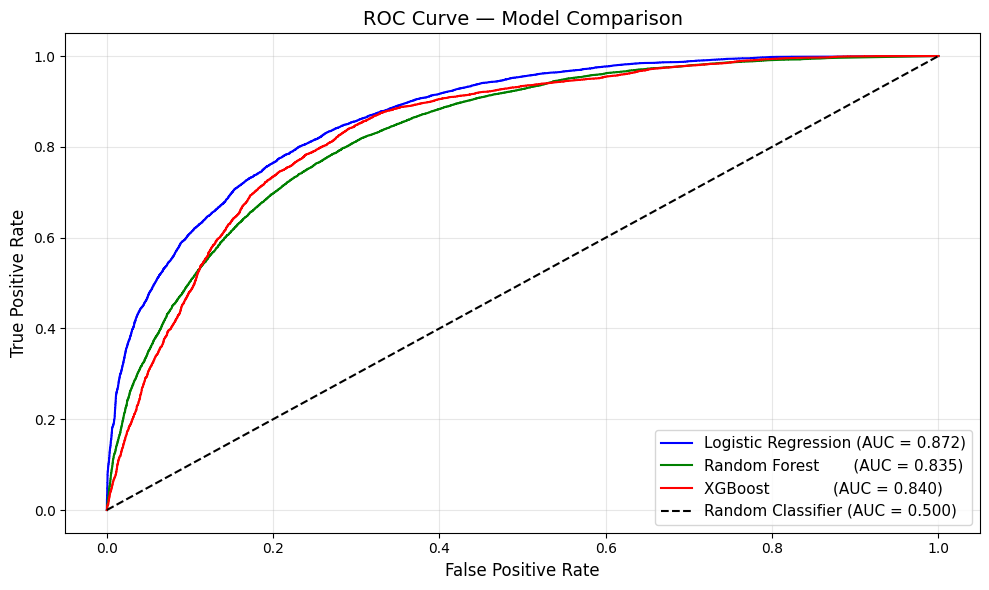

Logistic Regression AUC : 0.872
Random Forest AUC       : 0.835
XGBoost AUC             : 0.840


In [62]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get probabilities for all 3 models
lr_probs  = lr_model.predict_proba(X_test)[:, 1]
rf_probs  = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curves
lr_fpr,  lr_tpr,  _ = roc_curve(y_test, lr_probs)
rf_fpr,  rf_tpr,  _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# Calculate AUC scores
lr_auc  = roc_auc_score(y_test, lr_probs)
rf_auc  = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lr_fpr,  lr_tpr,  label=f'Logistic Regression (AUC = {lr_auc:.3f})',  color='blue')
plt.plot(rf_fpr,  rf_tpr,  label=f'Random Forest       (AUC = {rf_auc:.3f})',  color='green')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost             (AUC = {xgb_auc:.3f})', color='red')
plt.plot([0,1], [0,1], 'k--', label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve — Model Comparison', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Logistic Regression AUC : {lr_auc:.3f}")
print(f"Random Forest AUC       : {rf_auc:.3f}")
print(f"XGBoost AUC             : {xgb_auc:.3f}")

---------------------------------------------

## MODEL COMPARISION

In [63]:
comparison_df = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Random Forest',
        'XGBoost'
    ],
    'Accuracy': [0.78, 0.75, 0.77],
    'Win Precision': [0.79, 0.74, 0.75],
    'Win Recall': [0.68, 0.69, 0.72],
    'Win F1': [0.73, 0.71, 0.74],
    'False Negatives': [4291, 4242, 3765],
    'AUC Score': [
        round(lr_auc, 3),
        round(rf_auc, 3),
        round(xgb_auc, 3)
    ]
})

print(comparison_df.to_string(index=False))

              Model  Accuracy  Win Precision  Win Recall  Win F1  False Negatives  AUC Score
Logistic Regression      0.78           0.79        0.68    0.73             4291      0.872
      Random Forest      0.75           0.74        0.69    0.71             4242      0.835
            XGBoost      0.77           0.75        0.72    0.74             3765      0.840


-----------------------------------------------

## WIN PROBABILITY CURVE

**STEP 1 GET PROBABILITY OF ENTIRE df2 DATA SET**

1. Right now model only predicted on X_test
2. For win probability curves we need prediction on every ball of every match

In [64]:
# We need df2 with our feature columns
# Recreate the feature set from full df2 filtered data

df_full = df2[(df2['balls_bowled'] >= 12) & 
              (df2['balls_remaining'] > 0)].copy()

df_full = df_full[['match_id', 'batting_team', 'bowling_team',
                   'balls_bowled', 'balls_remaining', 'runs_so_far',
                   'wickets_fallen', 'wickets_in_hand', 'target',
                   'runs_needed', 'crr', 'rrr', 'pressure_index',
                   'won', 'season']].copy()

print(df_full.shape)

(120175, 15)


In [65]:
# Features only — same 10 columns model was trained on
features = ['balls_bowled', 'balls_remaining', 'runs_so_far',
            'wickets_fallen', 'wickets_in_hand', 'target',
            'runs_needed', 'crr', 'rrr', 'pressure_index']

# Get win probabilities using XGBoost (our best model)
df_full['win_probability'] = xgb_model.predict_proba(df_full[features])[:, 1]

# Quick check
print(df_full['win_probability'].describe().round(2))
print(df_full[['match_id', 'balls_bowled', 
               'win_probability']].head(10))

count    120175.00
mean          0.48
std           0.36
min           0.00
25%           0.09
50%           0.50
75%           0.83
max           1.00
Name: win_probability, dtype: float64
    match_id  balls_bowled  win_probability
11    598068            12         0.272078
12    598068            13         0.291465
13    598068            14         0.295150
14    598068            15         0.322506
15    598068            16         0.293526
16    598068            17         0.309595
17    598068            18         0.396449
18    598068            19         0.298646
19    598068            19         0.286797
20    598068            20         0.230687


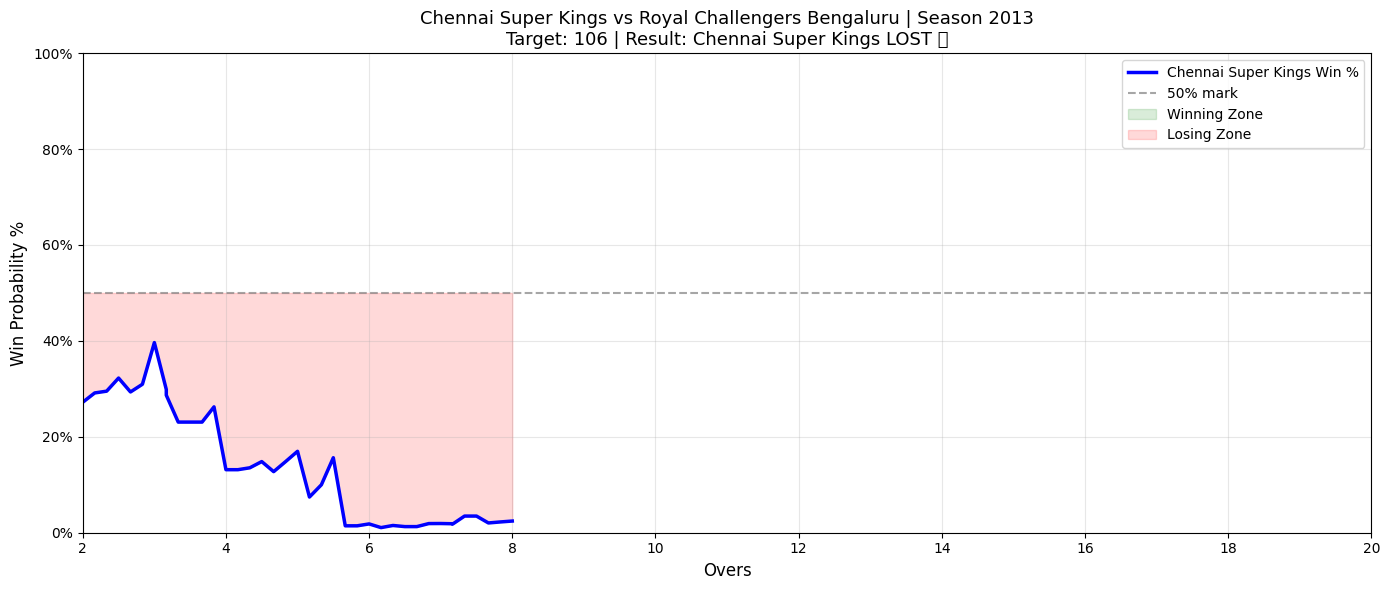

In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_win_probability(match_id, df_full):
    
    # Filter one match
    match = df_full[df_full['match_id'] == match_id].copy()
    
    # Get team names and match info
    batting_team = match['batting_team'].iloc[0]
    bowling_team = match['bowling_team'].iloc[0]
    season       = match['season'].iloc[0]
    target       = match['target'].iloc[0]
    result       = 'WON ✅' if match['won'].iloc[0] == 1 else 'LOST ❌'
    
    # Convert balls to overs for x axis
    match['over'] = match['balls_bowled'] / 6

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Win probability line
    ax.plot(match['over'], 
            match['win_probability'] * 100,
            color='blue', linewidth=2.5, label=f'{batting_team} Win %')
    
    # 50% reference line
    ax.axhline(y=50, color='gray', linestyle='--', 
               alpha=0.7, label='50% mark')
    
    # Shade WIN zone and LOSS zone
    ax.fill_between(match['over'], 
                    match['win_probability'] * 100, 
                    50,
                    where=(match['win_probability'] >= 0.5),
                    alpha=0.15, color='green', label='Winning Zone')
    
    ax.fill_between(match['over'],
                    match['win_probability'] * 100,
                    50,
                    where=(match['win_probability'] < 0.5),
                    alpha=0.15, color='red', label='Losing Zone')
    
    # Labels and formatting
    ax.set_xlabel('Overs', fontsize=12)
    ax.set_ylabel('Win Probability %', fontsize=12)
    ax.set_title(f'{batting_team} vs {bowling_team} | Season {season}\n'
                 f'Target: {int(target)} | Result: {batting_team} {result}',
                 fontsize=13)
    ax.set_xlim(2, 20)
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot first match
plot_win_probability(598068, df_full)

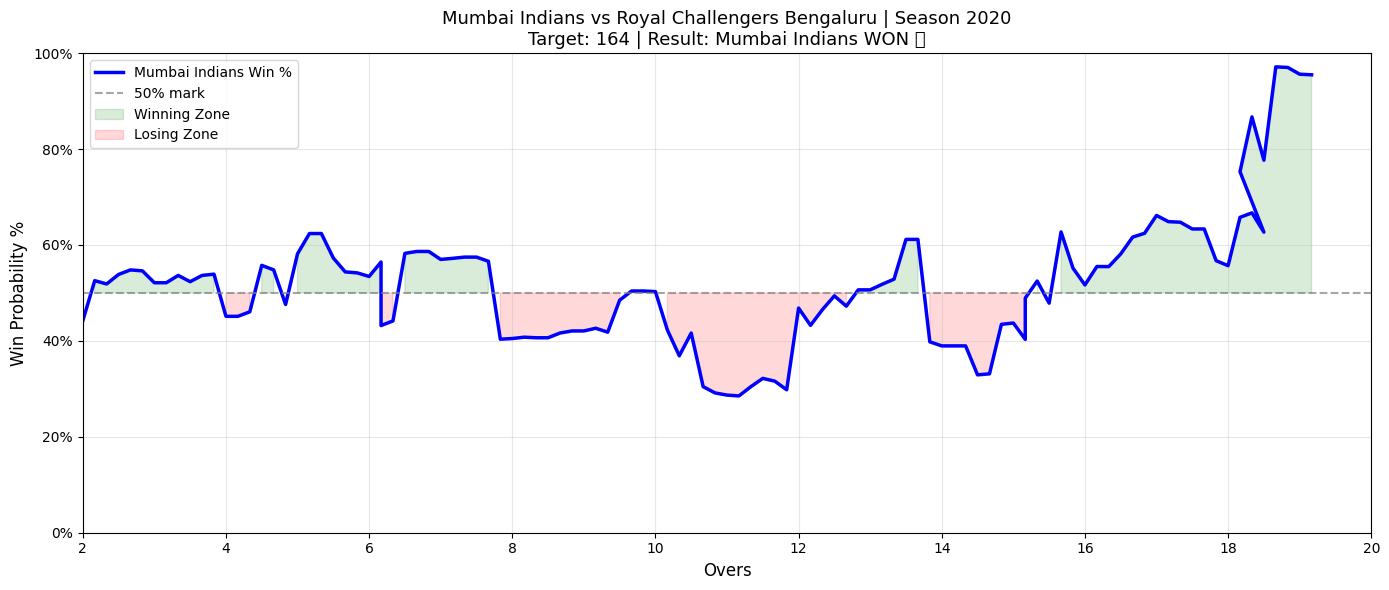

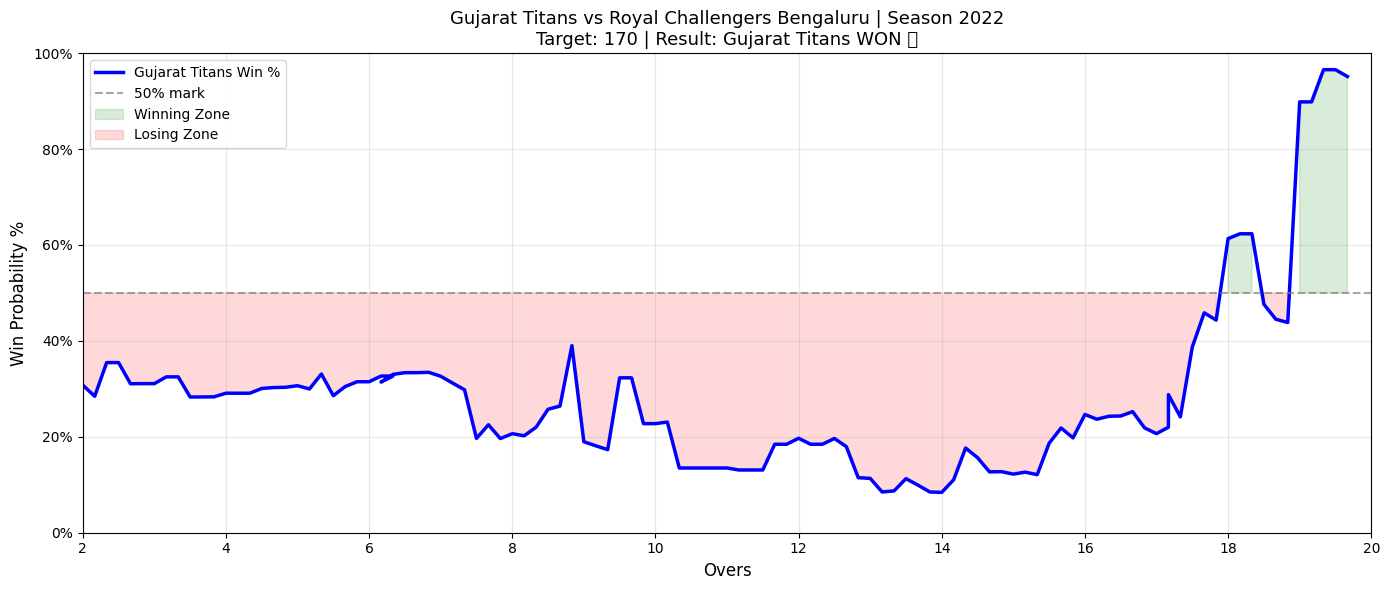

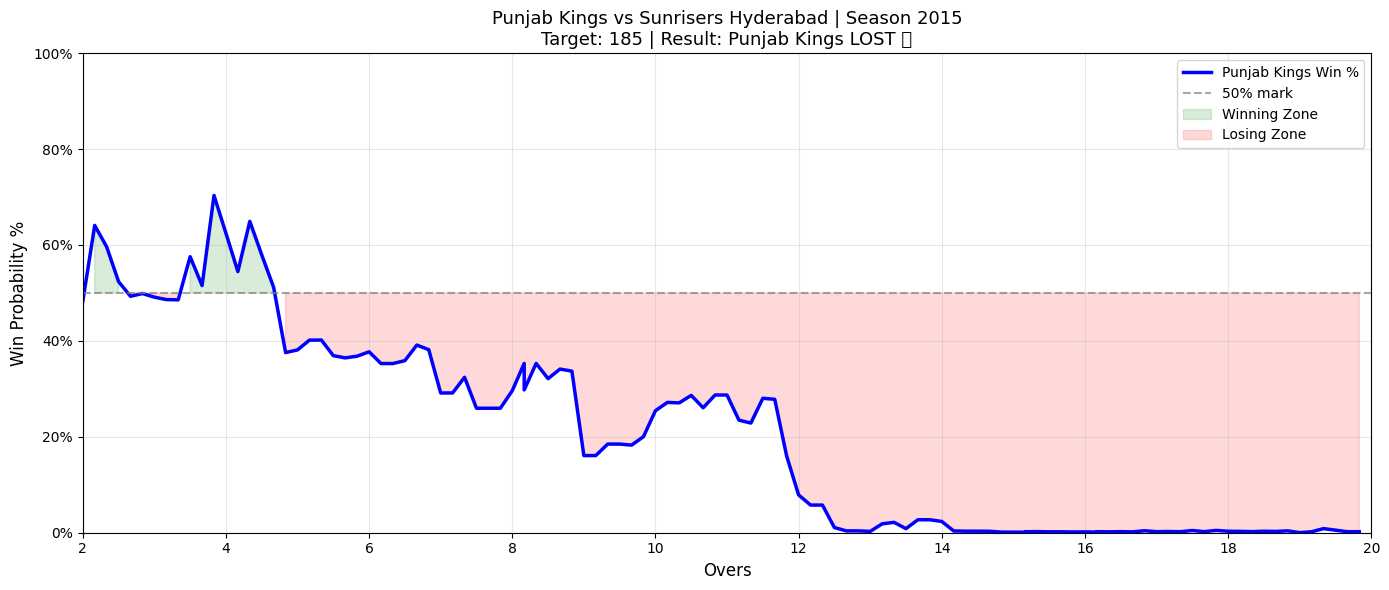

In [67]:
# Try a few different matches
interesting_matches = df_full['match_id'].unique()[5:8]
for mid in interesting_matches:
    plot_win_probability(mid, df_full)

--------------------------------------------------------------------

## FEATURE IMPORTANCE

**BUSINESS QUESTION**

Which factors matter MOST in predicting IPL match outcomes?

In [69]:
# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature'   : X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

           feature  importance
9   pressure_index    0.519430
8              rrr    0.151147
3   wickets_fallen    0.080068
5           target    0.079842
6      runs_needed    0.052672
7              crr    0.049078
2      runs_so_far    0.038185
0     balls_bowled    0.029577
1  balls_remaining    0.000000
4  wickets_in_hand    0.000000


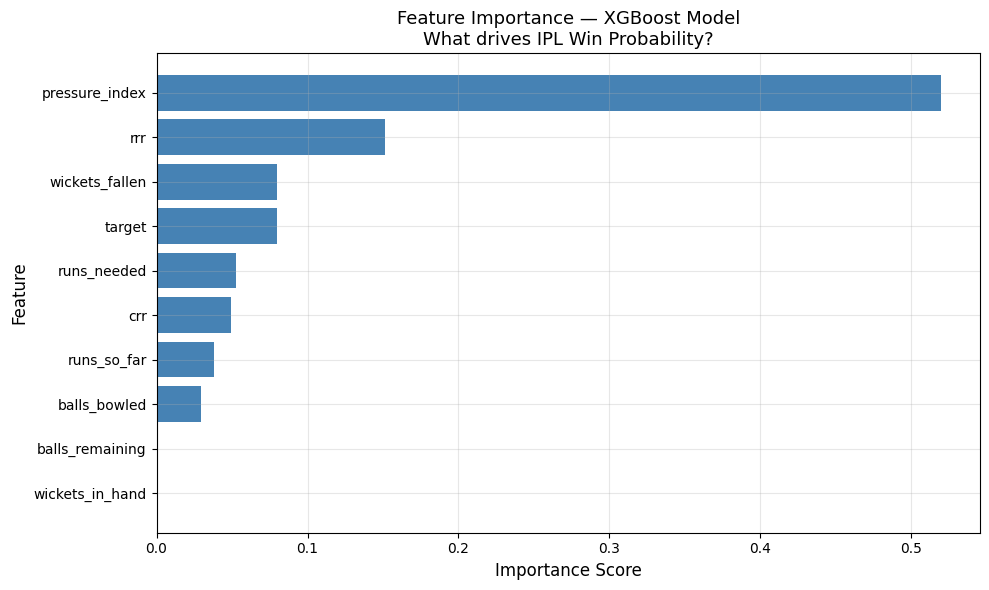

In [70]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], 
         feature_importance['importance'],
         color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance — XGBoost Model\nWhat drives IPL Win Probability?', 
          fontsize=13)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

----------------------------------------------

## FILE REQUIRED FOR TABLEAU

In [72]:
# FILE 1
tableau_winprob = df_full[[
    'match_id', 'season', 'batting_team', 
    'bowling_team', 'balls_bowled', 'runs_so_far',
    'wickets_fallen', 'target', 'runs_needed',
    'crr', 'rrr', 'pressure_index', 
    'win_probability', 'won'
]].copy()

tableau_winprob['over'] = (tableau_winprob['balls_bowled'] / 6).round(1)
tableau_winprob.to_csv('ipl_win_probability.csv', index=False)
print("File 1 saved:", tableau_winprob.shape)

# FILE 2
tableau_matches = df_full.groupby(
    ['match_id', 'season', 'batting_team', 
     'bowling_team', 'target', 'won']
).agg(
    avg_pressure  = ('pressure_index', 'mean'),
    max_pressure  = ('pressure_index', 'max'),
    avg_win_prob  = ('win_probability', 'mean'),
    total_wickets = ('wickets_fallen', 'max'),
    final_score   = ('runs_so_far', 'max')
).reset_index()

tableau_matches.to_csv('ipl_match_summary.csv', index=False)
print("File 2 saved:", tableau_matches.shape)

# FILE 3
feature_importance.to_csv('ipl_feature_importance.csv', index=False)
print("File 3 saved:", feature_importance.shape)


File 1 saved: (120175, 15)
File 2 saved: (1162, 11)
File 3 saved: (10, 2)
